## Group 180 drug randomly

### Import package

In [1]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from core.core import *

### Select drugs

In [2]:
drugbank = pd.read_csv('drugbank/DrugBank_DTI.csv')
targets_unique = list(set(drugbank['UniProt ID']))
targets_select = np.random.choice(targets_unique, 500, replace = False)

drugs_select, target_include = [],[]
for i in drugbank.index:
    if drugbank['UniProt ID'][i] in targets_select:
        drugs_select.append(drugbank['SMILES'][i])
        target_include.append(drugbank['UniProt ID'][i])
drugs_unique = list(set(drugs_select))[1:]
target_include = list(set(target_include))
print('There are {} targets of the selected'.format(len(target_include)))

# select test drugs
drugs_mols = [Chem.MolFromSmiles(s) for s in drugs_unique]
drugs_unique = [drugs_unique[i] for i in range(len(drugs_mols)) if drugs_mols[i] is not None]
drugs_test = np.random.choice(drugs_unique, 180, replace = False)

There are 500 targets of the selected


### Build test drug list

In [3]:
drugs_list = []
for smi in drugs_test:
    k = np.where(drugbank['SMILES'] == smi)[0]
    tar = list(drugbank['UniProt ID'][k])
    nam = drugbank['Name'][k[0]]
    drugs_list.append([nam, smi, tar])
drugs_list = pd.DataFrame(drugs_list)
drugs_list.columns = ['Name', 'SMILES', 'Targets']
print(drugs_list)

                                                  Name  \
0    1(R)-1-Acetamido-2-(3-Carboxyphenyl)Ethyl Boro...   
1            2-Acetamido-2-Deoxy-D-Glucono-1,5-Lactone   
2                                           Cefotaxime   
3    5-[(3R)-3-(5-methoxybiphenyl-3-yl)but-1-yn-1-y...   
4    2-[2-(1,3-Dioxo-1,3-Dihydro-2h-Isoindol-2-Yl)E...   
..                                                 ...   
175                                     Dexfosfoserine   
176                                           Arginine   
177  3-Hydroxymethyl-5-Aziridinyl-1methyl-2-[1h-Ind...   
178                                         Ripretinib   
179                                 Baloxavir marboxil   

                                                SMILES  \
0                CC(=O)N[C@@H](Cc1cccc(C(=O)O)c1)B(O)O   
1        CC(=O)N[C@H]1C(=O)O[C@H](CO)[C@@H](O)[C@@H]1O   
2    CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(C)...   
3    COc1cc(-c2ccccc2)cc([C@@H](C)C#Cc2c(C)nc(N)nc2...   
4    CCOc1ccc

### Calculate co-targets

In [4]:
all_targets = []
for tar in drugs_list['Targets']:
    all_targets += tar
co_targets_num = len(all_targets) - len(set(all_targets))
print('There are {} co-targets in the selected {} drugs'.format(co_targets_num, len(drugs_test)))

There are 637 co-targets in the selected 180 drugs


### Group the drugs optimally

[14:54:52] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[14:54:52] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[14:54:55] WARNING: not removing hydrogen atom without neighbors


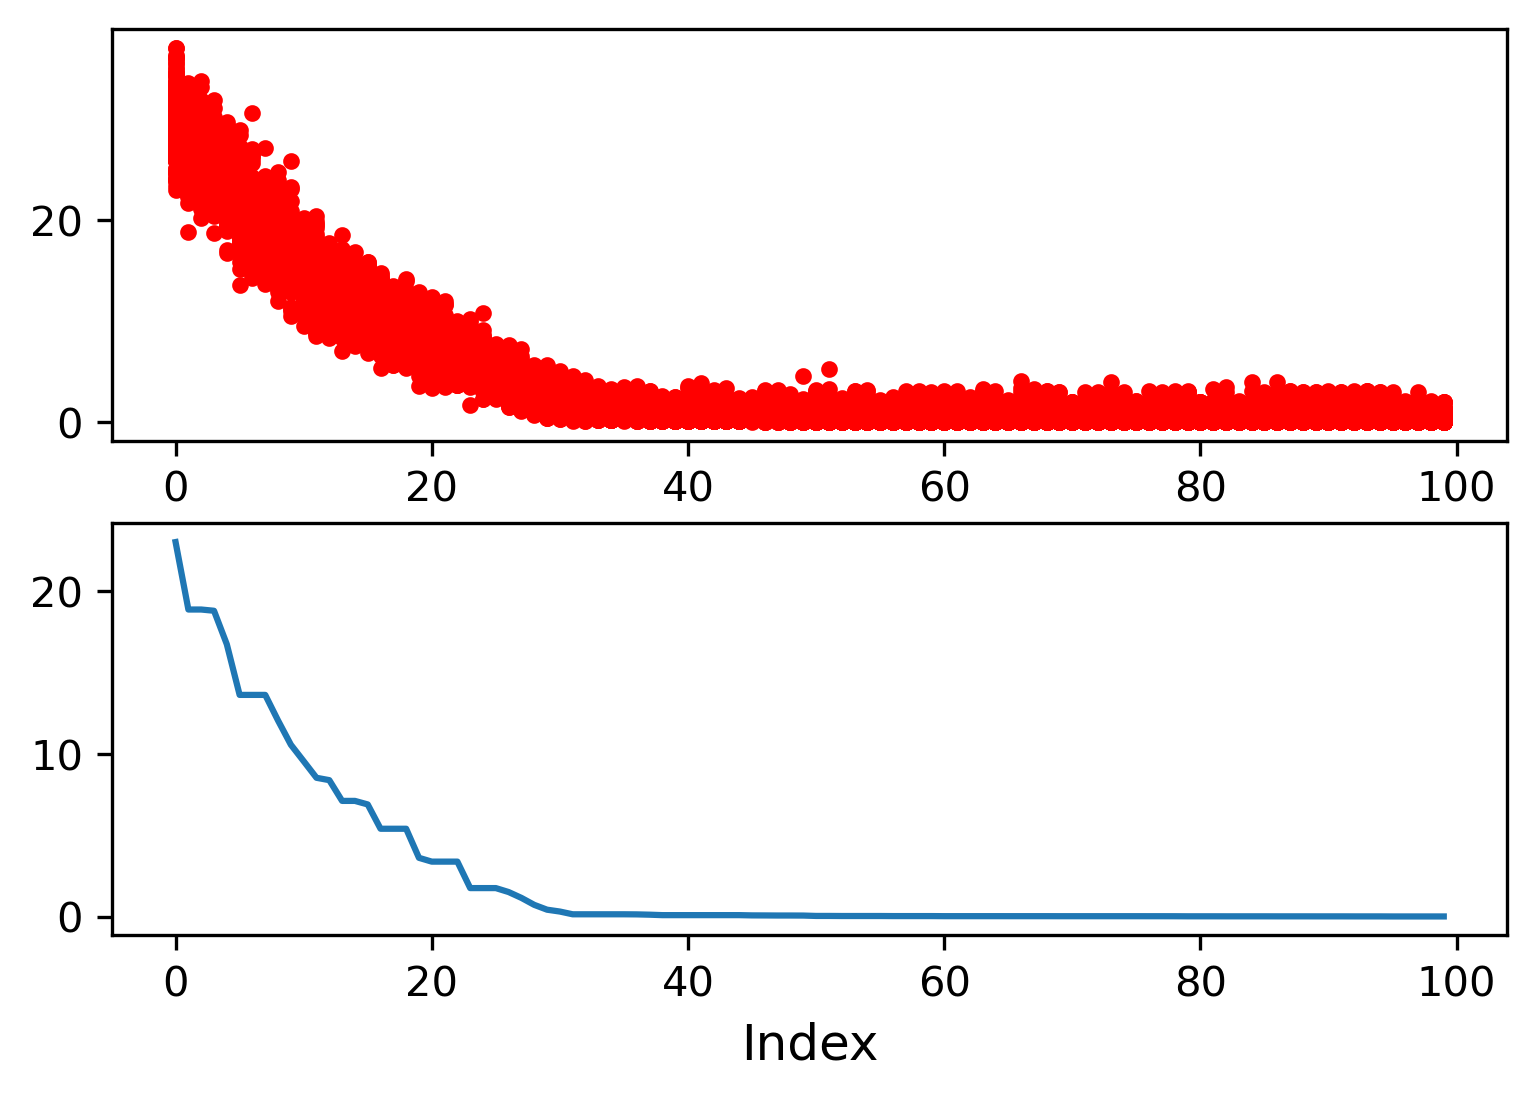

In [5]:
# predict drug targets
predicted_targets = predict_targets(drugs_list, threshold = 0.6)

# group drugs
pool_matrix = pd.read_excel('data/sensing_matrix_15drugs.xlsx')
pool_matrix[np.isnan(pool_matrix)] = 0
grouped_drugs = group_drugs(drugs_list, predicted_targets, pool_matrix)
grouped_drugs.to_csv('data/grouped_drugs_random_180.csv')

### Evalulating results

There are 214 co-targets in the grouped drugs
The median number of co-targets in the randomly grouped drugs is 341.0.


Text(0, 0.5, 'Randomized permutations')

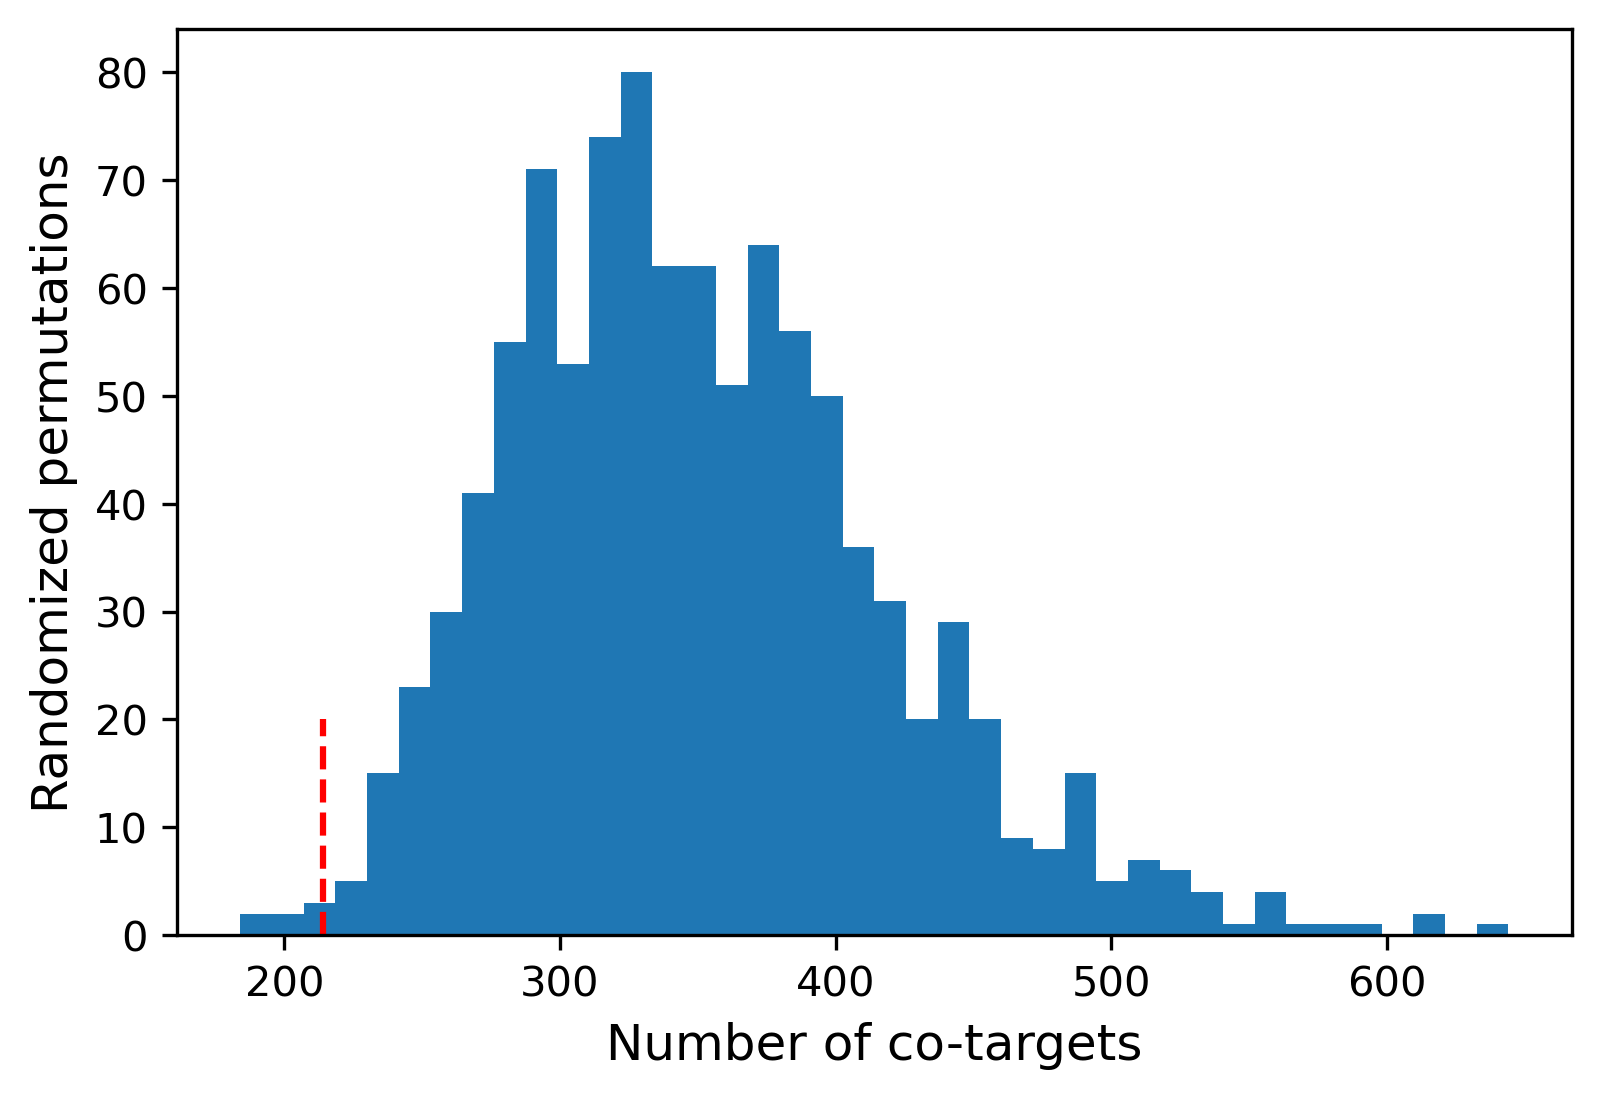

In [6]:
# define function calculating co-targets
def cal_cotargets(grouped_drugs):
    nums = []
    for i in range(grouped_drugs.shape[1]):
        targets = []
        for j in range(grouped_drugs.shape[0]):
            nam = grouped_drugs.iloc[j,i]
            k = np.where(drugs_list['Name'] == nam)[0][0]
            tar = list(drugs_list['Targets'][k])
            targets += tar
        count = collections.Counter(targets)
        num = sum([sum(range(s)) for s in count.values()])
        nums.append(num)
    return sum(nums)

# calculate co-targets after group
co_targets_num_grouped = cal_cotargets(grouped_drugs)
print('There are {} co-targets in the grouped drugs'.format(co_targets_num_grouped))

# calculate co-targets for randomly groups
co_targets_num_randoms = []
for i in range(1000):
    grouped_drugs_ran = pd.DataFrame(np.argsort(np.random.random(180)).reshape((15, 12)) )
    for j in range(grouped_drugs_ran.shape[0]):
        for k in range(grouped_drugs_ran.shape[1]):
            grouped_drugs_ran.iloc[j,k] = drugs_list['Name'][grouped_drugs_ran.iloc[j,k]]  
    co_targets_num_randoms.append(cal_cotargets(grouped_drugs_ran))
print('The median number of co-targets in the randomly grouped drugs is {}.'.format(np.median(co_targets_num_randoms)))

plt.figure(dpi = 300)
plt.hist(co_targets_num_randoms, bins = 40)
plt.vlines(co_targets_num_grouped, 0, 20, color = 'red', linestyles='dashed')
plt.xlabel('Number of co-targets', fontsize = 12)
plt.ylabel('Randomized permutations', fontsize = 12)